## Import library

In [1]:
## Import library
import sys
sys.path.append('../')

from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
# from models import Informer, Autoformer, Transformer
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric

import numpy as np
import torch
import torch.nn as nn
from torch import optim

import os
import time

import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

## Load Data

In [2]:
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from torch.utils.data import DataLoader

In [3]:
shuffle_flag = True
drop_last = True
batch_size = 32
freq = 'h'

Data = Dataset_ETT_hour

timeenc = 1

root_path = '../dataset'
data_path = 'ETTh1.csv'
flag='test'
seq_len = 96
label_len = 48
pred_len = 48
features = 'S'
target = 'OT'

In [4]:
Data = Dataset_ETT_hour
dataset = Data(root_path='../dataset',
                data_path='ETTh1.csv',
                flag='test',
                size=[seq_len, label_len, pred_len],
                features=features,
                target=target,
                timeenc=timeenc,
                freq=freq)

data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=10,
        drop_last=drop_last) 


In [5]:
batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(data_loader))

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_x = batch_x.float().to(device)
batch_y = batch_y.float().to(device)

batch_x_mark = batch_x_mark.float().to(device)
batch_y_mark = batch_y_mark.float().to(device)

In [7]:
# decoder input
dec_inp = torch.zeros_like(batch_y[:, pred_len:, :]).float()
dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)


## Load Model 

In [8]:
from models import Informer, Autoformer, Transformer, Reformer

In [9]:
import argparse
import random

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='test', help='model id')
parser.add_argument('--model', type=str, required=False, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=False, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='../dataset/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='S',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=48, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')
parser.add_argument('--enc_in', type=int, default=1, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=1, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=3, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

args = parser.parse_args(args=[])

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)



Args in experiment:
Namespace(is_training=1, model_id='test', model='Autoformer', data='ETTm1', root_path='../dataset/', data_path='ETTh1.csv', features='S', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=48, bucket_size=4, n_hashes=4, enc_in=1, dec_in=1, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=3, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3')


In [10]:
model = Autoformer.Model(args).float()

if args.use_multi_gpu and args.use_gpu:
    model = nn.DataParallel(model, device_ids=args.device_ids)

model.to(device)


Model(
  (decomp): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encode

In [11]:
setting = 'ETTh1_96_48_Autoformer_ETTh1_ftS_sl96_ll48_pl48_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/'

model.load_state_dict(torch.load('../checkpoints/model_result/checkpoint.pth'))


<All keys matched successfully>

In [12]:
seasonality, trend, dec_out, attns = model.customize_forward(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [13]:
print(seasonality.shape)
print(trend.shape)
print(dec_out.shape)

torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([32, 96, 1])


## Visualization

In [14]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [15]:
dec_out_np = dec_out.detach().cpu().numpy()
batch_y_np = batch_y.detach().cpu().numpy()
batch_x_np = batch_x.detach().cpu().numpy()
seasonal_np =seasonality.detach().cpu().numpy()
trend_np = trend.detach().cpu().numpy()

pred = dec_out_np[:, -pred_len:, :]
true = batch_y_np[:, -pred_len:, :]
input = batch_x_np
seasonal = seasonal_np 
trend = trend_np

========================idx: 0========================


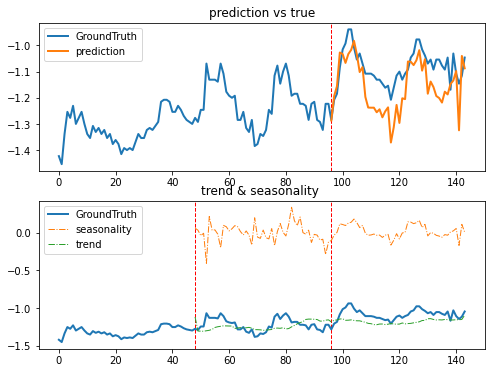

========================idx: 1========================


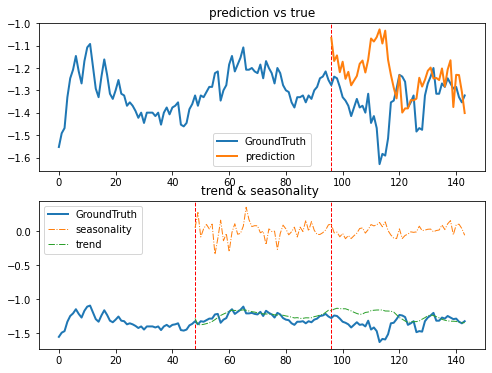

========================idx: 2========================


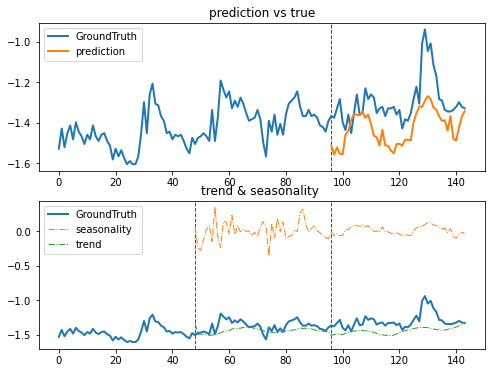

========================idx: 3========================


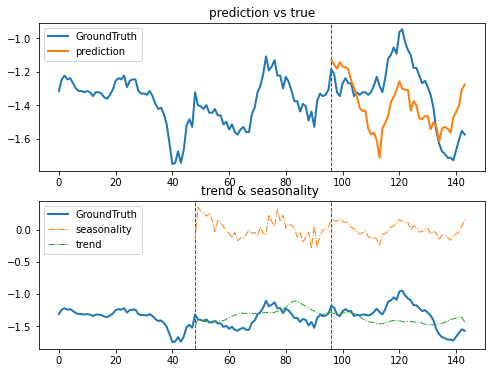

========================idx: 4========================


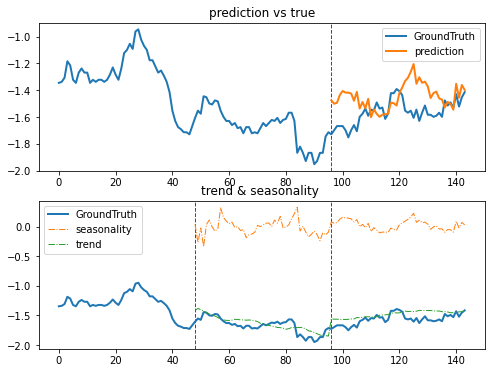

In [16]:
for idx in range(5):
    print(f'========================idx: {idx}========================')

    fig, axs = plt.subplots(2,1, figsize=(8,6))

    x = np.arange(144)
    y1 = np.arange(96, 144)
    y2 = np.arange(48, 144)

    gt = np.concatenate((input[idx, :, -1], true[idx, :, -1]), axis=0)
    pd = pred[idx]
    se = seasonal[idx]
    tr = trend[idx]

    axs[0].axvline(x=96, color='r', linewidth=1, ls='--')
    axs[0].plot(x, gt, label='GroundTruth', linewidth=2)
    axs[0].plot(y1, pd, label='prediction', linewidth=2)
    axs[0].legend()
    axs[0].set_title('prediction vs true')

    axs[1].axvline(x=48, color='r', linewidth=1, ls='--')
    axs[1].axvline(x=96, color='r', linewidth=1, ls='--')
    axs[1].plot(x, gt, label='GroundTruth', linewidth=2)
    axs[1].plot(y2, se, label='seasonality', linewidth=1, ls='-.')
    axs[1].plot(y2, tr, label='trend', linewidth=1, ls='-.')
    axs[1].legend()
    axs[1].set_title('trend & seasonality ')

    plt.show()
    


In [17]:
setting = "ETTh1_96_48_Autoformer_ETTh1_ftS_sl96_ll48_pl48_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_'Exp'_0"

metrics = np.load(f'../results/{setting}/metrics.npy')
pred = np.load(f'../results/{setting}/pred.npy')
true = np.load(f'../results/{setting}/true.npy')


In [18]:
pred.shape

(2816, 48, 1)

In [19]:
true.shape

(2816, 48, 1)

In [20]:
metrics

array([0.2318102 , 0.08318132, 0.28841174, 0.19050042, 0.06504858],
      dtype=float32)